In [38]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

### Split de dataset

In [39]:
valid_size = 0.2

transform = transforms.ToTensor()

train_data = datasets.MNIST(root='data', 
                            train=True,
                            download=True, 
                            transform=transform)

test_data = datasets.MNIST(root='data',
                           train=False,
                           download=True,
                           transform=transform)


num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=batch_size,
                                           sampler=train_sampler,
                                           num_workers=0)

valid_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=batch_size,
                                           sampler=valid_sampler,
                                           num_workers=0)

test_loader = torch.utils.data.DataLoader(test_data,
                                          batch_size=batch_size,
                                          num_workers=0)

### Definir Modelo

In [40]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        # x = self.dropout(x)
        x = self.fc3(x)
        return x

model = Net()
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [41]:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

### Early Stop implementacion

In [42]:
# https://github.com/Bjarten/early-stopping-pytorch/blob/master/pytorchtools.py

In [43]:
import numpy as np
import torch

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [44]:
def train_model(model, batch_size, patience, n_epochs):
    
    train_losses = []

    valid_losses = []

    avg_train_losses = []

    avg_valid_losses = [] 
    
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    
    for epoch in range(1, n_epochs + 1):

        # entrenamiento del modelo
        model.train()
        for batch, (data, target) in enumerate(train_loader, 1):
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        # evaluar modelo
        model.eval()
        for data, target in valid_loader:
            output = model(data)
            loss = criterion(output, target)
            valid_losses.append(loss.item())

        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)
        
        epoch_len = len(str(n_epochs))
        
        print_msg = (f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                     f'train_loss: {train_loss:.5f} ' +
                     f'valid_loss: {valid_loss:.5f}')
        
        print(print_msg)
        
        train_losses = []
        valid_losses = []
        
        early_stopping(valid_loss, model)
        
        if early_stopping.early_stop:
            print("Early stopping")
            break
        
    # Cargar el mejor modelo guardado
    model.load_state_dict(torch.load('checkpoint.pt'))

    return  model, avg_train_losses, avg_valid_losses


In [45]:
batch_size = 256
n_epochs = 100

train_loader, test_loader, valid_loader = create_datasets(batch_size)

patience = 20

model, train_loss, valid_loss = train_model(model, batch_size, patience, n_epochs)

[  1/100] train_loss: 1.15972 valid_loss: 0.45380
Validation loss decreased (inf --> 0.453801).  Saving model ...
[  2/100] train_loss: 0.37985 valid_loss: 0.34307
Validation loss decreased (0.453801 --> 0.343067).  Saving model ...
[  3/100] train_loss: 0.30749 valid_loss: 0.28926
Validation loss decreased (0.343067 --> 0.289258).  Saving model ...
[  4/100] train_loss: 0.26729 valid_loss: 0.27200
Validation loss decreased (0.289258 --> 0.271997).  Saving model ...
[  5/100] train_loss: 0.23632 valid_loss: 0.23341
Validation loss decreased (0.271997 --> 0.233407).  Saving model ...
[  6/100] train_loss: 0.21139 valid_loss: 0.20262
Validation loss decreased (0.233407 --> 0.202621).  Saving model ...
[  7/100] train_loss: 0.18834 valid_loss: 0.18812
Validation loss decreased (0.202621 --> 0.188124).  Saving model ...
[  8/100] train_loss: 0.17125 valid_loss: 0.17927
Validation loss decreased (0.188124 --> 0.179268).  Saving model ...
[  9/100] train_loss: 0.15653 valid_loss: 0.16021
Val

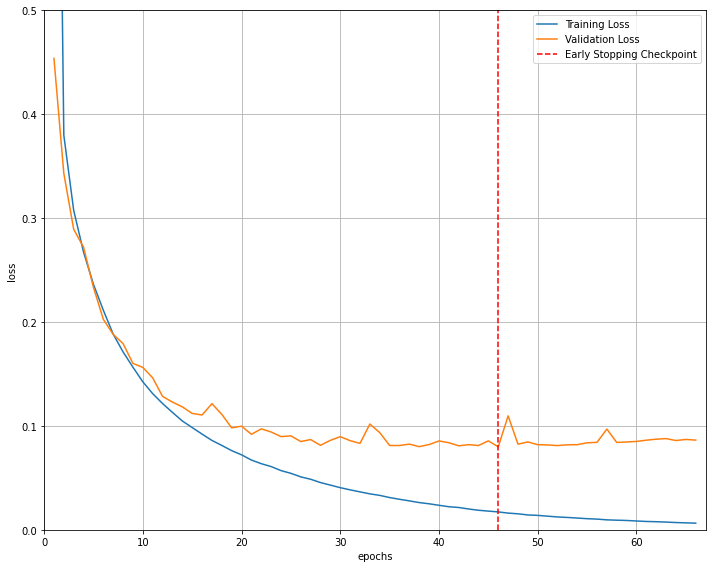

In [46]:
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss')

# find position of lowest validation loss
minposs = valid_loss.index(min(valid_loss))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0, 0.5) # consistent scale
plt.xlim(0, len(train_loss)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches='tight')

In [47]:

test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() 

for data, target in test_loader:
    if len(target.data) != batch_size:
        break
    output = model(data)

    loss = criterion(output, target)

    test_loss += loss.item()*data.size(0)
    _, pred = torch.max(output, 1)
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.082085

Test Accuracy of     0: 98% (969/979)
Test Accuracy of     1: 99% (1126/1133)
Test Accuracy of     2: 97% (1009/1030)
Test Accuracy of     3: 97% (985/1008)
Test Accuracy of     4: 97% (953/980)
Test Accuracy of     5: 96% (858/890)
Test Accuracy of     6: 97% (936/956)
Test Accuracy of     7: 97% (997/1027)
Test Accuracy of     8: 95% (932/973)
Test Accuracy of     9: 96% (972/1008)

Test Accuracy (Overall): 97% (9737/9984)


/var/folders/5p/l30m88v51q9b0q19jz_zwv3w0000gn/T/ipykernel_20185/1720625792.py:11: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])


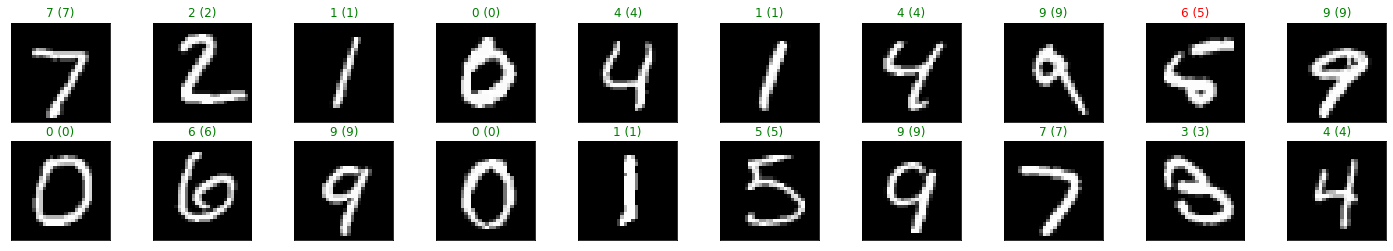

In [48]:

dataiter = iter(test_loader)
images, labels = dataiter.next()


output = model(images)
_, preds = torch.max(output, 1)
images = images.numpy()

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))